In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [2]:
raw_test_data, info = tfds.load(name="div2k", with_info=True, split='validation')

In [3]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 256, 256, 3])

In [6]:
data = raw_test_data.take(100)
def representative_dataset_gen():
  for example in data:
    image = example['lr'].numpy()
    image = tf.image.resize(image, (256, 256))
    image = image[np.newaxis,:,:,:]
    yield [image]

In [4]:
data = raw_test_data.take(5)
def representative_dataset_gen():
    image_size = 256
    raw_test_dato = []
    for file in data:
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        #Quantizing the image between -1,1;
        image = (2.0 / 255.0) * np.float32(image) - 1.0
        #image = np.asarray(image).astype(np.float32)
        image = image[np.newaxis,:,:,:]
        raw_test_dato.append(image)

    for data in raw_test_dato:
        yield [data]

In [7]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]

#I don't see the following flags making any different effect.
converter.experimental_new_converter = True
converter.experimental_new_quantizer = True

converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.allow_custom_ops = False
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()


# Save the TF Lite model.
esrgan_quant_model_path = './ESRGAN_quant_256.tflite'
with tf.io.gfile.GFile(esrgan_quant_model_path, 'wb') as f:
  f.write(tflite_model)

In [12]:
test_img_path = tf.keras.utils.get_file('lr.jpg', 'https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/super_resolution/android/app/src/main/assets/lr-1.jpg')

In [8]:
def run_inference(mode_path):
  # Load Image
  lr = cv2.imread("cayman.jpg")
  lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
  lr = tf.expand_dims(lr, axis=0)
  lr = tf.cast(lr, tf.float32)

  # Load TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_path=mode_path)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Run the model
  interpreter.set_tensor(input_details[0]['index'], lr)
  interpreter.invoke()

  # Extract the output and postprocess it
  output_data = interpreter.get_tensor(output_details[0]['index'])
  sr = tf.squeeze(output_data, axis=0)
  sr = tf.clip_by_value(sr, 0, 255)
  sr = tf.round(sr)
  sr = tf.cast(sr, tf.uint8)

  return sr

In [9]:
# integer quantization
sr_int8_quant = run_inference(esrgan_quant_model_path)

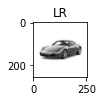

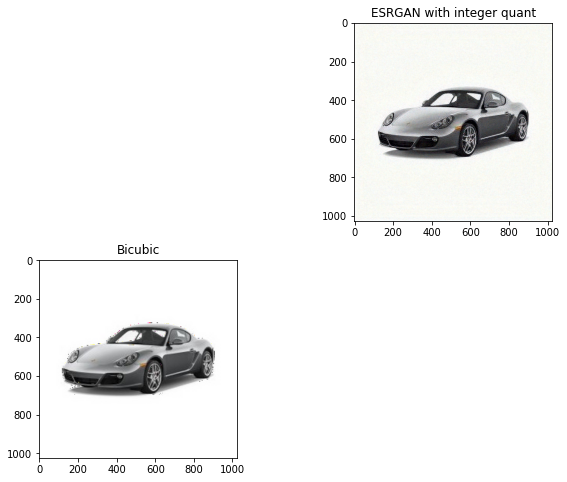

In [10]:
lr = cv2.imread("cayman.jpg")
lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)
lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)

plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr.numpy());

fig = plt.figure(figsize=(16, 8))


ax2 = fig.add_subplot(2, 3, 2)
ax2.set_title(f'ESRGAN with integer quant')
ax2.imshow(sr_int8_quant.numpy());


bicubic = tf.image.resize(lr, [1024, 1024], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
ax4 = fig.add_subplot(2, 3, 4)
ax4.set_title(f'Bicubic')
ax4.imshow(bicubic.numpy());

plt.show()